### 1. 安装依赖库

In [2]:
! pip install jieba

### 2. 导入依赖库

In [3]:
import jieba
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

### 3. 数据加载

In [4]:
train_data = pd.read_csv('data/train.tsv', sep='\t')
valid_data = pd.read_csv('data/dev.tsv', sep='\t')
test_data = pd.read_csv('data/test.tsv', sep='\t') 
x_train, y_train = train_data.text_a.values, train_data.label.values # 训练集
x_valid, y_valid = valid_data.text_a.values, valid_data.label.values # 验证集
x_test, y_test = test_data.text_a.values, test_data.label.values # 测试集

In [5]:
x_train, y_train

(array(['选择珠江花园的原因就是方便，有电动扶梯直接到达海边，周围餐馆、食廊、商场、超市、摊位一应俱全。酒店装修一般，但还算整洁。 泳池在大堂的屋顶，因此很小，不过女儿倒是喜欢。 包的早餐是西式的，还算丰富。 服务吗，一般',
        '15.4寸笔记本的键盘确实爽，基本跟台式机差不多了，蛮喜欢数字小键盘，输数字特方便，样子也很美观，做工也相当不错',
        '房间太小。其他的都一般。。。。。。。。。', ...,
        '虽是观景房,不过我住的楼层太低(19楼)看不到江景,但地点很好,离轻轨临江门站和较场口站(起点)很近,解放碑就在附近(大约100多公尺吧)!',
        '性价比不错，交通方便。行政楼层感觉很好，只是早上8点楼上装修，好吵。 中餐厅档次太低，虽然便宜，但是和酒店档次不相配。',
        '跟心灵鸡汤没什么本质区别嘛，至少我不喜欢这样读经典，把经典都解读成这样有点去中国化的味道了'], dtype=object),
 array([1, 1, 0, ..., 1, 1, 0], dtype=int64))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Jun\AppData\Local\Temp\jieba.cache
Loading model cost 0.823 seconds.
Prefix dict has been built successfully.


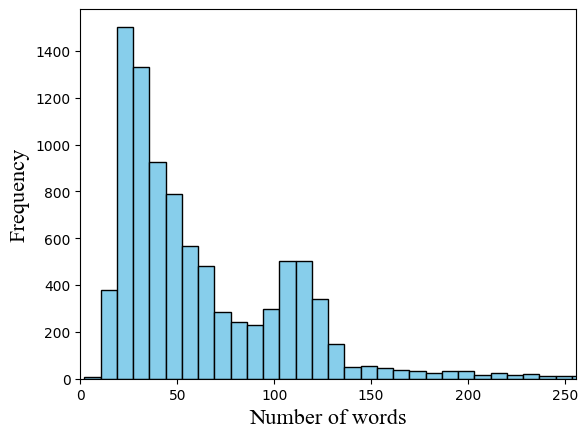

In [6]:
import matplotlib.pyplot as plt

# 数据词频分析
word_counts = train_data.text_a.apply(lambda x: len(list(jieba.cut(x))))
word_counts_df = pd.DataFrame({'Word_Count': word_counts})

# 绘制频率直方图
plt.hist(word_counts, bins=3200, color='skyblue', edgecolor='black')
plt.xlabel('Number of words', fontsize=16, fontname='Times New Roman')
plt.ylabel('Frequency', fontsize=16, fontname='Times New Roman')
# plt.title('Word Count Frequency Distribution')
plt.xlim(0, 256)
plt.show()

### 4. 构建词汇表

In [8]:
vocab = set()
cut_docs = train_data.text_a.apply(lambda x: jieba.cut(x)).values
for doc in cut_docs:
    for word in doc:
        if word.strip():
            vocab.add(word.strip())

# 将词表写入本地vocab.txt文件
with open('data/vocab.txt', 'w') as file:
    for word in  vocab:
        file.write(word)
        file.write('\n')

print("len(vocal) = %d" % len(vocab))
list(vocab)[:10]

len(vocal) = 35091


['斩客', '酒巴', '天赋', '220G', '他们', '逗乐', '梅园', '两情相悦', '柯布', '没有冬天']

### 5. 定义配置参数

In [9]:
class Config():
    embedding_dim = 300 # 词向量维度
    max_seq_len = 200   # 文章最大词数 200
    vocab_file = 'data/vocab.txt' # 词汇表文件路径
config = Config()

### 6. 定义预处理类

In [10]:
class Preprocessor():
    def __init__(self, config):
        self.config = config
        # 初始化词和id的映射词典，预留0给padding字符，1给词表中未见过的词
        token2idx = {"[PAD]": 0, "[UNK]": 1} # {word：id}
        with open(config.vocab_file, 'r') as reader:
            for index, line in enumerate(reader):
                token = line.strip()
                token2idx[token] = index+2
                
        self.token2idx = token2idx
        
    def transform(self, text_list):
        # 文本分词，并将词转换成相应的id, 最后不同长度的文本padding长统一长度，后面补0
        idx_list = [[self.token2idx.get(word.strip(), self.token2idx['[UNK]']) for word in jieba.cut(text)] for text in text_list]
        idx_padding = pad_sequences(idx_list, self.config.max_seq_len, padding='post')
        
        return idx_padding

In [11]:
preprocessor = Preprocessor(config)
res_show = preprocessor.transform(['性价比不错，交通方便。', '房间太小。其他的都一般。'])
res_show = preprocessor.transform(['我爱你猪咪'])
res_show.shape

(1, 200)

### 7. 定义模型类

In [12]:
class TextCNN(object):
    def __init__(self, config):
        self.config = config
        self.preprocessor = Preprocessor(config)
        self.class_name = {0: '负面', 1: '正面'}
    
    def build_model(self):
        # 模型架构搭建
        idx_input = tf.keras.layers.Input((self.config.max_seq_len,))
        input_embedding = tf.keras.layers.Embedding(len(self.preprocessor.token2idx),
                    self.config.embedding_dim,
                    input_length=self.config.max_seq_len,
                    mask_zero=True)(idx_input)
        input_embedding_dropout = tf.keras.layers.Dropout(rate=0.4)(input_embedding)

        convs = []
        for kernel_size in [3, 4, 5]:
            c = tf.keras.layers.Conv1D(128, kernel_size, activation='relu')(input_embedding_dropout)
            c = tf.keras.layers.GlobalMaxPooling1D()(c)
            convs.append(c)
        fea_cnn = tf.keras.layers.Concatenate()(convs)
        # fea_cnn_dropout = tf.keras.layers.Dropout(rate=0.4)(fea_cnn)
        fea_cnn_dropout = fea_cnn
        
        fea_dense = tf.keras.layers.Dense(128, activation='relu')(fea_cnn_dropout)
        output = tf.keras.layers.Dense(2, activation='softmax')(fea_dense)
        
        model = tf.keras.Model(inputs=idx_input, outputs=output)
        model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])     
        
        model.summary()
        
        self.model = model
    
    def fit(self, x_train, y_train, x_valid=None, y_valid=None, epochs=5, batch_size=128, callbacks=None, **kwargs):
        # 训练
        self.build_model()
        
        x_train = self.preprocessor.transform(x_train)
        valid_data = None
        if x_valid is not None and y_valid is not None:
            x_valid = self.preprocessor.transform(x_valid)
            valid_data = (x_valid, y_valid)

        self.model.fit(
            x=x_train,
            y=y_train,
            validation_data= valid_data,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            **kwargs
        )
        
    def evaluate(self, x_test, y_test):
        # 评估
        x_test = self.preprocessor.transform(x_test)
        y_pred_probs = self.model.predict(x_test)
        y_pred = np.argmax(y_pred_probs, axis=-1)
        result = classification_report(y_test, y_pred, target_names=['负面', '正面'])
        print(result)
        
        
    def single_predict(self, text):
        # 预测
        input_idx = self.preprocessor.transform([text])
        predict_prob = self.model.predict(input_idx)[0]
        predict_label_id = np.argmax(predict_prob)
        
        predict_label_name = self.class_name[predict_label_id]
        predict_label_prob = predict_prob[predict_label_id]
        
        return predict_label_name, predict_label_prob
    
    def load_model(self, ckpt_file):
        self.build_model()
        self.model.load_weights(ckpt_file)

### 8. 启动训练

In [13]:
# 定义early stop早停回调函数
patience = 6
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)

# 定义checkpoint回调函数
checkpoint_prefix = './checkpoints/textcnn_imdb_ckpt'
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    save_best_only=True)

# 初始化模型类，启动训练
textcnn = TextCNN(config)
textcnn.fit(x_train, y_train, x_valid, y_valid, epochs=50, callbacks=[early_stop, checkpoint_callback]) # 训练

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     10527900    input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 200, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 198, 128)     115328      dropout[0][0]                    
______________________________________________________________________________________________

### 9. 测试评估

In [14]:
textcnn.evaluate(x_test, y_test) # 测试集评估

              precision    recall  f1-score   support

          负面       0.88      0.93      0.91       592
          正面       0.93      0.88      0.90       608

    accuracy                           0.91      1200
   macro avg       0.91      0.91      0.90      1200
weighted avg       0.91      0.91      0.90      1200



### 10. 离线加载预测

In [15]:
textcnn = TextCNN(config)
textcnn.load_model(checkpoint_prefix)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 300)     10527900    input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 200, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 198, 128)     115328      dropout_1[0][0]                  
____________________________________________________________________________________________

In [16]:
textcnn.single_predict("外观很漂亮，出人意料地漂亮，做工非常好") # 单句预测

('正面', 0.9999317)

In [17]:
textcnn.single_predict("书的内容没什么好说的，主要是纸张、印刷太差，所用的纸非常粗糙比一般的盗版书还要差，裁的也不好。") # 单句预测

('负面', 0.9995846)